# Estimating tempo and beat

In [119]:
import librosa
import pandas as pd
from pathlib import Path
from IPython.display import Audio
import librosa.display
import matplotlib.pyplot as plt
from tqdm notebookort tqdm

Dataset: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

In [120]:
dataset_path = Path("ML4Music/data/GTZAN/Data/genres_original")

typical tempos by musical genre

In [167]:
default_tempo = 120
typical_tempo = {
    "reggae": 60,
    "blues": default_tempo,
    "classical": default_tempo,
    "country": default_tempo,
    "disco": default_tempo,
    "hiphop": 85,
    "jazz": 120,
    "metal": 100,
    "pop": 100,
    "rock": 110
}

# Dataloader

all data will be loaded to DataFrame, so we can watch some statistics about the beat.<br /> 
some files are corrupted, hence the 'try-except' <br /> 
we can use the y_perc component for more accurate results, but loading the data will be signifcatly slower

In [186]:
data = list()
for fin in tqdm(dataset_path.rglob("*.wav")):
    sample_data = dict()
    sample_data['fname'] = fin.name
    sample_data['genre'] = fin.parent.name
    try:
        sample_data['y'], sample_data['sr'] = librosa.load(str(fin))
    except:
        continue
    #y_harm, y_perc = librosa.effects.hpss(sample_data['y'])
    onset_env = librosa.onset.onset_strength(y=sample_data['y'], sr=sample_data['sr'] ,aggregate=np.median)
    sample_data['tempo'], sample_data['beat'] = librosa.beat.beat_track(onset_envelope=onset_env,sr=sr, start_bpm=typical_tempo[sample_data['genre']])
    data.append(sample_data)
    
df = pd.DataFrame(data)

944it [01:05, 14.78it/s]/Users/tomer/miniforge3/envs/ml4music/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
1000it [01:08, 14.58it/s]


lets see the mean tempo estimated by genre <br /> 
you will notice estimated tempo is very close to the nominal value for the genre, that's because the algorithm under the hood is weighting the estimated tempo using the nominal tempo provided.<br /> 
http://labrosa.ee.columbia.edu/projects/beattrack/

In [181]:
df.groupby("genre")["tempo"].mean().to_frame().sort_values(by="tempo")

,tempo
genre,
reggae,67.143026
hiphop,87.833855
pop,98.083929
metal,107.865407
country,110.858840
rock,113.381383
jazz,114.937353
disco,120.341798
blues,120.781960


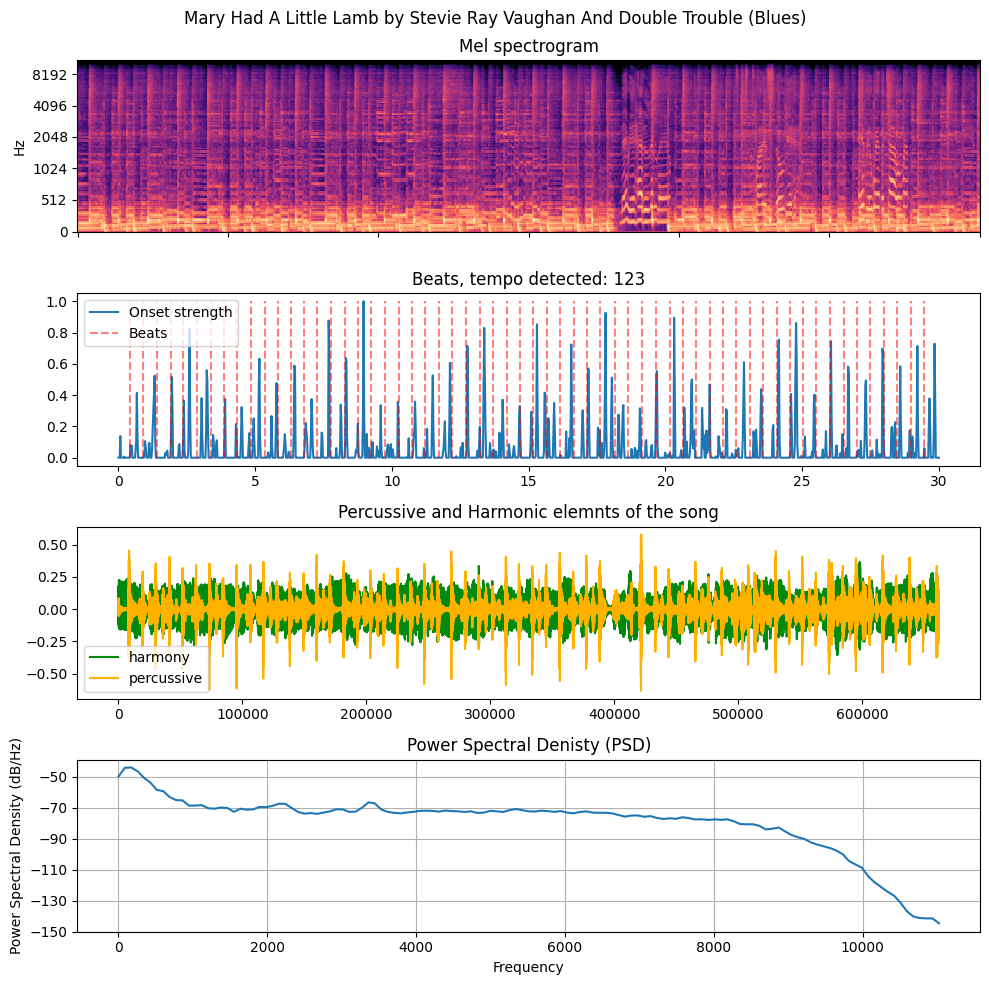

In [208]:
genre = "blues"  

cdf = df[df["genre"]==genre]
idx = random.randint(0, cdf.count()[0])
row = cdf.iloc[idx]
fname = row["fname"]
y = row["y"]
sr = row["sr"]
tempo = row["tempo"]
beats = row["beat"]

Audio(y, rate=sr)

hop_length = 512
fig, ax = plt.subplots(nrows=4, figsize=(10, 10))
fig.suptitle("Mary Had A Little Lamb by Stevie Ray Vaughan And Double Trouble (Blues)")
times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max),y_axis='mel', x_axis='time', hop_length=hop_length, ax=ax[0])
ax[0].label_outer()
ax[0].set(title='Mel spectrogram')

ax[1].plot(times, librosa.util.normalize(onset_env),label='Onset strength')
ax[1].vlines(times[beats], 0, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
ax[1].legend()
ax[1].set(title=f'Beats, tempo detected: {int(tempo)}')

y_harm, y_perc = librosa.effects.hpss(y)
ax[2].plot(y_harm, color = '#028A0F', label="harmony")
ax[2].plot(y_perc, color = '#FFB100', label="percussive")
ax[2].legend()
ax[2].set(title=f'Percussive and Harmonic elemnts of the song')

ax[3].psd(y,Fs=sr)
ax[3].set(title=f'Power Spectral Denisty (PSD)')

plt.tight_layout()
plt.show()
